## Visualize Attributes

In this section we will further visualize and interpret the most important attributes of the data set from the results we saw in the simple statistics.  We will also explore relationships between attributes in order to gain insight into how the variables might help explain the response variable 'project_is_approved'.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df_train = pd.read_csv('train.csv')
df_resources = pd.read_csv('resources.csv')
train_resource = pd.merge(df_train, df_resources, on="id", how='left')
df_train[df_train.teacher_prefix.isnull()]
train_resource[train_resource.description.isnull()].head()
t2 = train_resource.pivot_table(index = ['id', 'description'],
                                values='quantity', 
                                aggfunc=np.sum)
t2.reset_index(inplace=True)
train_resource = pd.merge(train_resource,
                          t2, 
                          on=['id', 'description'], 
                          how='right',
                          suffixes=('_Orig', '_True'))

train_resource = train_resource.drop_duplicates()
train_resource = train_resource.drop('quantity_Orig', axis=1)
train_resource = train_resource.rename(columns={'quantity_True': 'True_Quantity'})
train_resource['Total_Cost'] = train_resource.price * train_resource.True_Quantity
Total_cost = train_resource.pivot_table(values=['Total_Cost','True_Quantity'],
                                        index='id',
                                        aggfunc={'Total_Cost' : np.sum, 'True_Quantity' : np.sum})
Total_cost.reset_index(level=0, inplace = True)

df_train = df_train.merge(Total_cost, on='id', how='left')
df_train['Average_item_cost'] = df_train.Total_Cost  / df_train.True_Quantity
#df_train.describe()
#df_train.info()

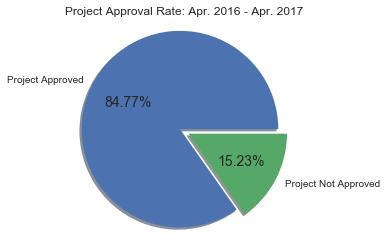

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

aprvd = float(len(df_train[df_train.project_is_approved != 0]))/len(df_train) * 100
Naprvd = float(len(df_train[df_train.project_is_approved== 0]))/len(df_train) * 100

##https://matplotlib.org/examples/pie_and_polar_charts/pie_demo_features.html
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Project Approved', 'Project Not Approved'
sizes = [aprvd, Naprvd]
#colors = ['xkcd:teal', 'xkcd:grey']
explode = (0.0,0.1)  
plt.rcParams['font.size'] = 14.0

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=True, startangle=360)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Project Approval Rate: Apr. 2016 - Apr. 2017')
plt.show()

The pie chart above looks at project approval rates across the entire time period of the dataset provided.  As mentioned when we looked at the simple statistics, we see that the approval rate is high, with only 15% of project submissions declined.  

This may suggest that the submission process was set-up only to weed out applications that were not applicable to the overall mission of donorschoose.org, or perhaps even to act as a filter to discourage fraudulent applications. 

Next we will look at the approval rate by the year and month of the application submission.

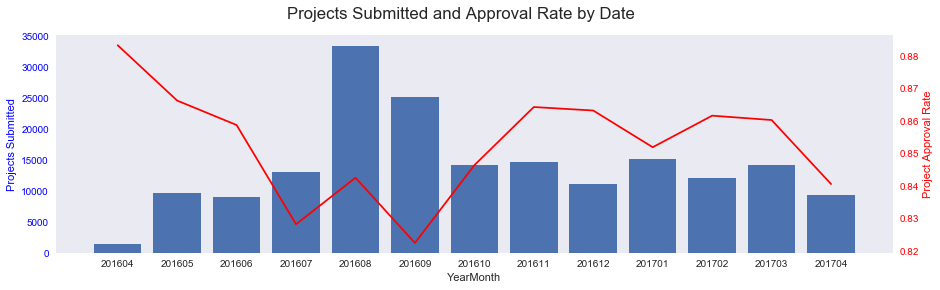

In [3]:
df_train['proj_submitted_count'] = 1
date_features = ['project_submitted_datetime']
df_train[date_features] = df_train[date_features].astype('datetime64[ns]')
df_train['project_submitted_YM'] = df_train['project_submitted_datetime'].apply(lambda x: x.strftime('%Y%m'))
#https://stackoverflow.com/questions/32474434/trying-to-plot-a-line-plot-on-a-bar-plot-using-matplotlib
projSub = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='project_submitted_YM',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projSub.reset_index(level=0, inplace = True)

projSub['proj_approval_rate'] = (projSub.project_is_approved/projSub.proj_submitted_count)
del projSub['project_is_approved']

date = projSub.project_submitted_YM  
projSubmitted = projSub.proj_submitted_count
projApprvdRate = projSub.proj_approval_rate

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Date')

#Plot bars
#projSubmitted.plot()
plt.bar(date,projSubmitted)
ax1.set_xlabel('YearMonth')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(date,projApprvdRate, color = 'r')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

The chart above shows how the approval rate fluctuated over the thirteen month time period.  The blue bars represent submission volume and the red line represents the approval rate within the same month.  The range of the approval rate axis is intentionally small in order to focus on the changes by month.  Note that the total range of approval rates is only 6% during the thirteen month period.

The submission volumes peaked in August and September, a time when most teachers are returning from summer break.  The dip in approval rates during this same time period may be caused be a lack of resources on the reviewers' side, i.e., they may become slightly more strict with the applications as a result of increased submission volume.  

Another possibility is that there is a lagged time component where the glut of new applications aren't fully reviewed and decisioned until one or two months after the applications were submitted.  Approval rates rose in October and November.  This may be due to the residual volume from August and September being processed.

Now we will turn our attention towards the state the school is located.

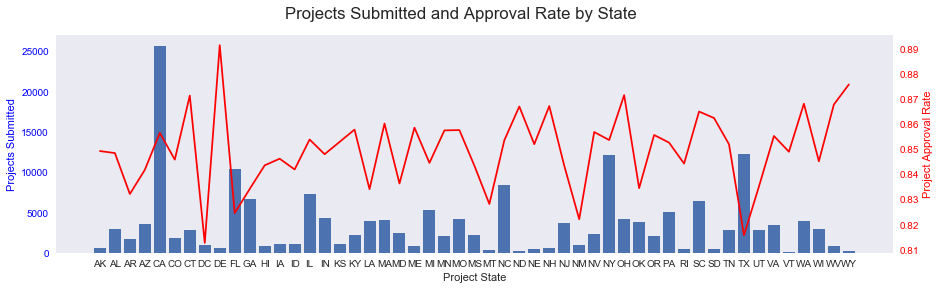

,school_state,proj_submitted_count,proj_approval_rate
8,DE,589,0.891341
50,WY,177,0.875706
35,OH,4139,0.871467
6,CT,2766,0.871294
47,WA,3903,0.868050


In [4]:
projState = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='school_state',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projState.reset_index(level=0, inplace = True)

projState['proj_approval_rate'] = (projState.project_is_approved/projState.proj_submitted_count)
del projState['project_is_approved']

state = projState.school_state  
projSubmitted = projState.proj_submitted_count
projApprvdRate = projState.proj_approval_rate

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by State')

#Plot bars
#projSubmitted.plot()
plt.bar(state,projSubmitted)
ax1.set_xlabel('Project State')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(state,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()
#sort table
projState = projState.sort_values('proj_approval_rate',ascending=False)
projState.head()

In [16]:
projState.tail()

,school_state,proj_submitted_count,proj_approval_rate
26,MT,384,0.828125
9,FL,10359,0.824500
32,NM,916,0.822052
43,TX,12304,0.815670
7,DC,902,0.812639


The chart above shows project submission volume and approval rates by state. The two tables show the top five states by approval rate (top table) and the bottom five states by approval rate (bottom table).  One overlay that may be very interesting for future analysis would be to try to determine the driver of the differences in approvals rates between the top and bottom five states.  Is this difference purely random, or is it statistically significant?  Demographic features from these states could potentially be useful in answering this question.

Let's now turn our attention to the quantities requested and see if that could cause a difference in approval rates.

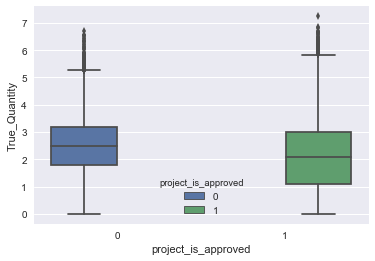

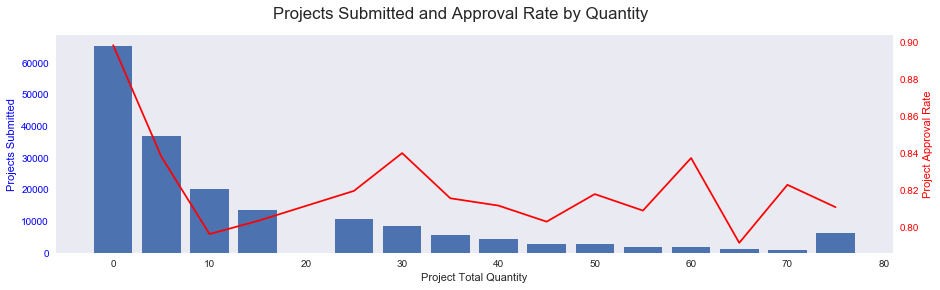

In [5]:
#boxplot quantity by is_approved
sns.boxplot(x="project_is_approved", 
            y=df_train["True_Quantity"].apply(np.log),
            hue="project_is_approved",
 data=df_train)

##bar and line plot quantity by is_approved
df_train['total_quantity_group'] = pd.cut(df_train['True_Quantity']
                                      , bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,1e6]
                                      , labels = [0,5,10,15,25,30,35,40,45,50,55,60,65,70,75])
df_train['total_quantity_group'] = df_train['total_quantity_group'].astype(np.float64)

projQuant = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='total_quantity_group',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projQuant.reset_index(level=0, inplace = True)

projQuant['proj_approval_rate'] = (projQuant.project_is_approved/projQuant.proj_submitted_count)
del projQuant['project_is_approved']
quant = projQuant.total_quantity_group  
projSubmitted = projQuant.proj_submitted_count
projApprvdRate = projQuant.proj_approval_rate

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Quantity')

#Plot bars
plt.bar(quant,projSubmitted, width = 4)
ax1.set_xlabel('Project Total Quantity')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(quant,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

The chart directly above shows projects submitted and approval rates by the quantity of materials requested.  The box plot above the chart is a log transform of the quantity requested split between applications that were approved and not approved.

The lower quartile range of the box plot suggests that applications that request lower quantities have a better chance of being approved, which is the same result we saw using the Rank-Sum tests in the simple statistics section. This is furthered even more by the chart where there does seem to be a negative correlation between increases in quantity and the likelyhood of an application being approved.  We will revisit the correlations and address them directly at the end of this section.

Next we will look at the same analysis as above, but for total cost instead of quantity.

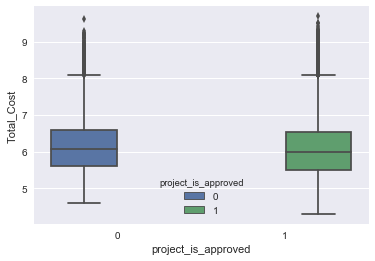

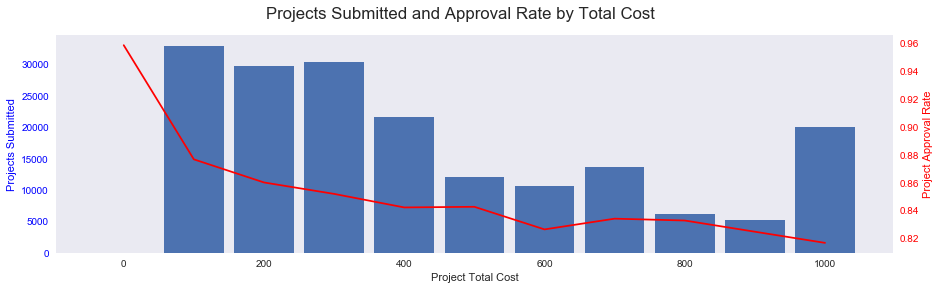

In [6]:
##boxplot total cost by is_approved
sns.boxplot(x="project_is_approved", 
            y=df_train["Total_Cost"].apply(np.log),
            hue="project_is_approved",
 data=df_train)

df_train['total_cost_group'] = pd.cut(df_train['Total_Cost']
                                      , bins = [0,100,200,300,400,500,600,700
                                                ,800,900,1000,1e6]
                                      ,labels = [0,100,200,300,400,500,600,700
                                                ,800,900,1000])
df_train['total_cost_group'] = df_train['total_cost_group'].astype(np.float64)

projCost = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='total_cost_group',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projCost.reset_index(level=0, inplace = True)

projCost['proj_approval_rate'] = (projCost.project_is_approved/projCost.proj_submitted_count)
del projCost['project_is_approved']

cost = projCost.total_cost_group  
#print(state)
projSubmitted = projCost.proj_submitted_count
#print(projSubmitted)
projApprvdRate = projCost.proj_approval_rate
#print(projApprvdRate)

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Total Cost')

#Plot bars
#projSubmitted.plot()
plt.bar(cost,projSubmitted, width = 85)
ax1.set_xlabel('Project Total Cost')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(cost,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

The chart directly above shows projects submitted and approval rates by the total cost of materials requested.  The box plot above the chart is a log transform of the total cost split between applications that were approved and not approved.

The box plot for total cost does not show a radical difference in terms of quantity requested between applications that were approved and applications that were not approved. In fact, the box plots look almost identical.  

However, in the chart directly above there does seem to be a negative correlation between increases in total cost and the likelyhood of an application being approved - which was also brought up in the simple statistics section.

In the final analysis for this section we will consider approval rates by the number of projects previously submitted.

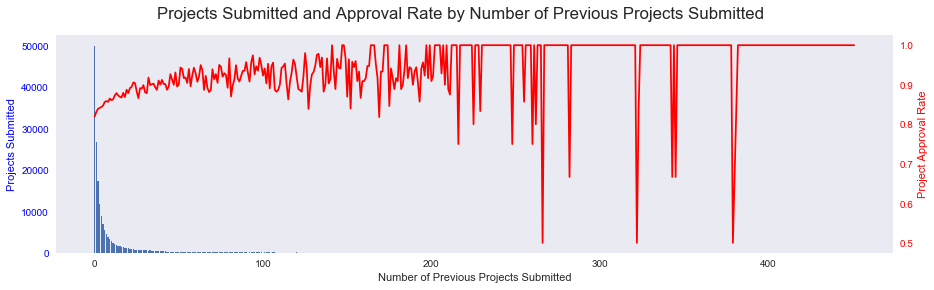

In [7]:
projPrev = df_train.pivot_table(values=['proj_submitted_count','project_is_approved'],
                                        index='teacher_number_of_previously_posted_projects',
                                        aggfunc={'proj_submitted_count' : np.sum
                                               , 'project_is_approved' : np.sum})
projPrev.reset_index(level=0, inplace = True)

projPrev['proj_approval_rate'] = (projPrev.project_is_approved/projPrev.proj_submitted_count)
del projPrev['project_is_approved']

prev = projPrev.teacher_number_of_previously_posted_projects  
#print(state)
projSubmitted = projPrev.proj_submitted_count
#print(projSubmitted)
projApprvdRate = projPrev.proj_approval_rate
#print(projApprvdRate)

#Plot graph with 2 y axes
fig, ax1 = plt.subplots()
fig.set_figwidth(15)
fig.suptitle('Projects Submitted and Approval Rate by Number of Previous Projects Submitted')

#Plot bars
#projSubmitted.plot()
plt.bar(prev,projSubmitted)
ax1.set_xlabel('Number of Previous Projects Submitted')
ax1.grid(False)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Projects Submitted', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
plt.plot(prev,projApprvdRate, color = 'red')
ax2.grid(False)

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Project Approval Rate', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
plt.show()

In the simple statistics section we looked at approval rates by the number of previously posted projects.  The chart above is another way of showing this.  Approval rates increase as teachers gain more experience with the application process.  This is not surprising, but was included in this analysis to display the extreme right skew for this variable.  As with the correlations between quantity and total cost, this will be examined more closely in the next section.

### Summary

Some important insights have been gained from this analysis.  Overall approval rates are high, and the chances of an application being approved are increased for those who request lower quantities and lower total costs in their applications.  The volume of total applications submitted also increases the likelyhood of acceptance.  Timing may also be a factor for approval, although a data set that contained a longer time period would be helpful to perform further analysis for this.  Finally, teachers in certain states seem to have better overall odds of application acceptance.  As mentioned earlier, it would be interesting to overlay additional socio-economic attributes to see if this can help to add more insight into the differences amongst states.

## Explore Joint Attributes

In this section we will further examine the relationships between attributes that was begun in the Data Visualization section.

Let's take a look at the continuous variables in a scatter matrix to get a first look at the relationships between them.

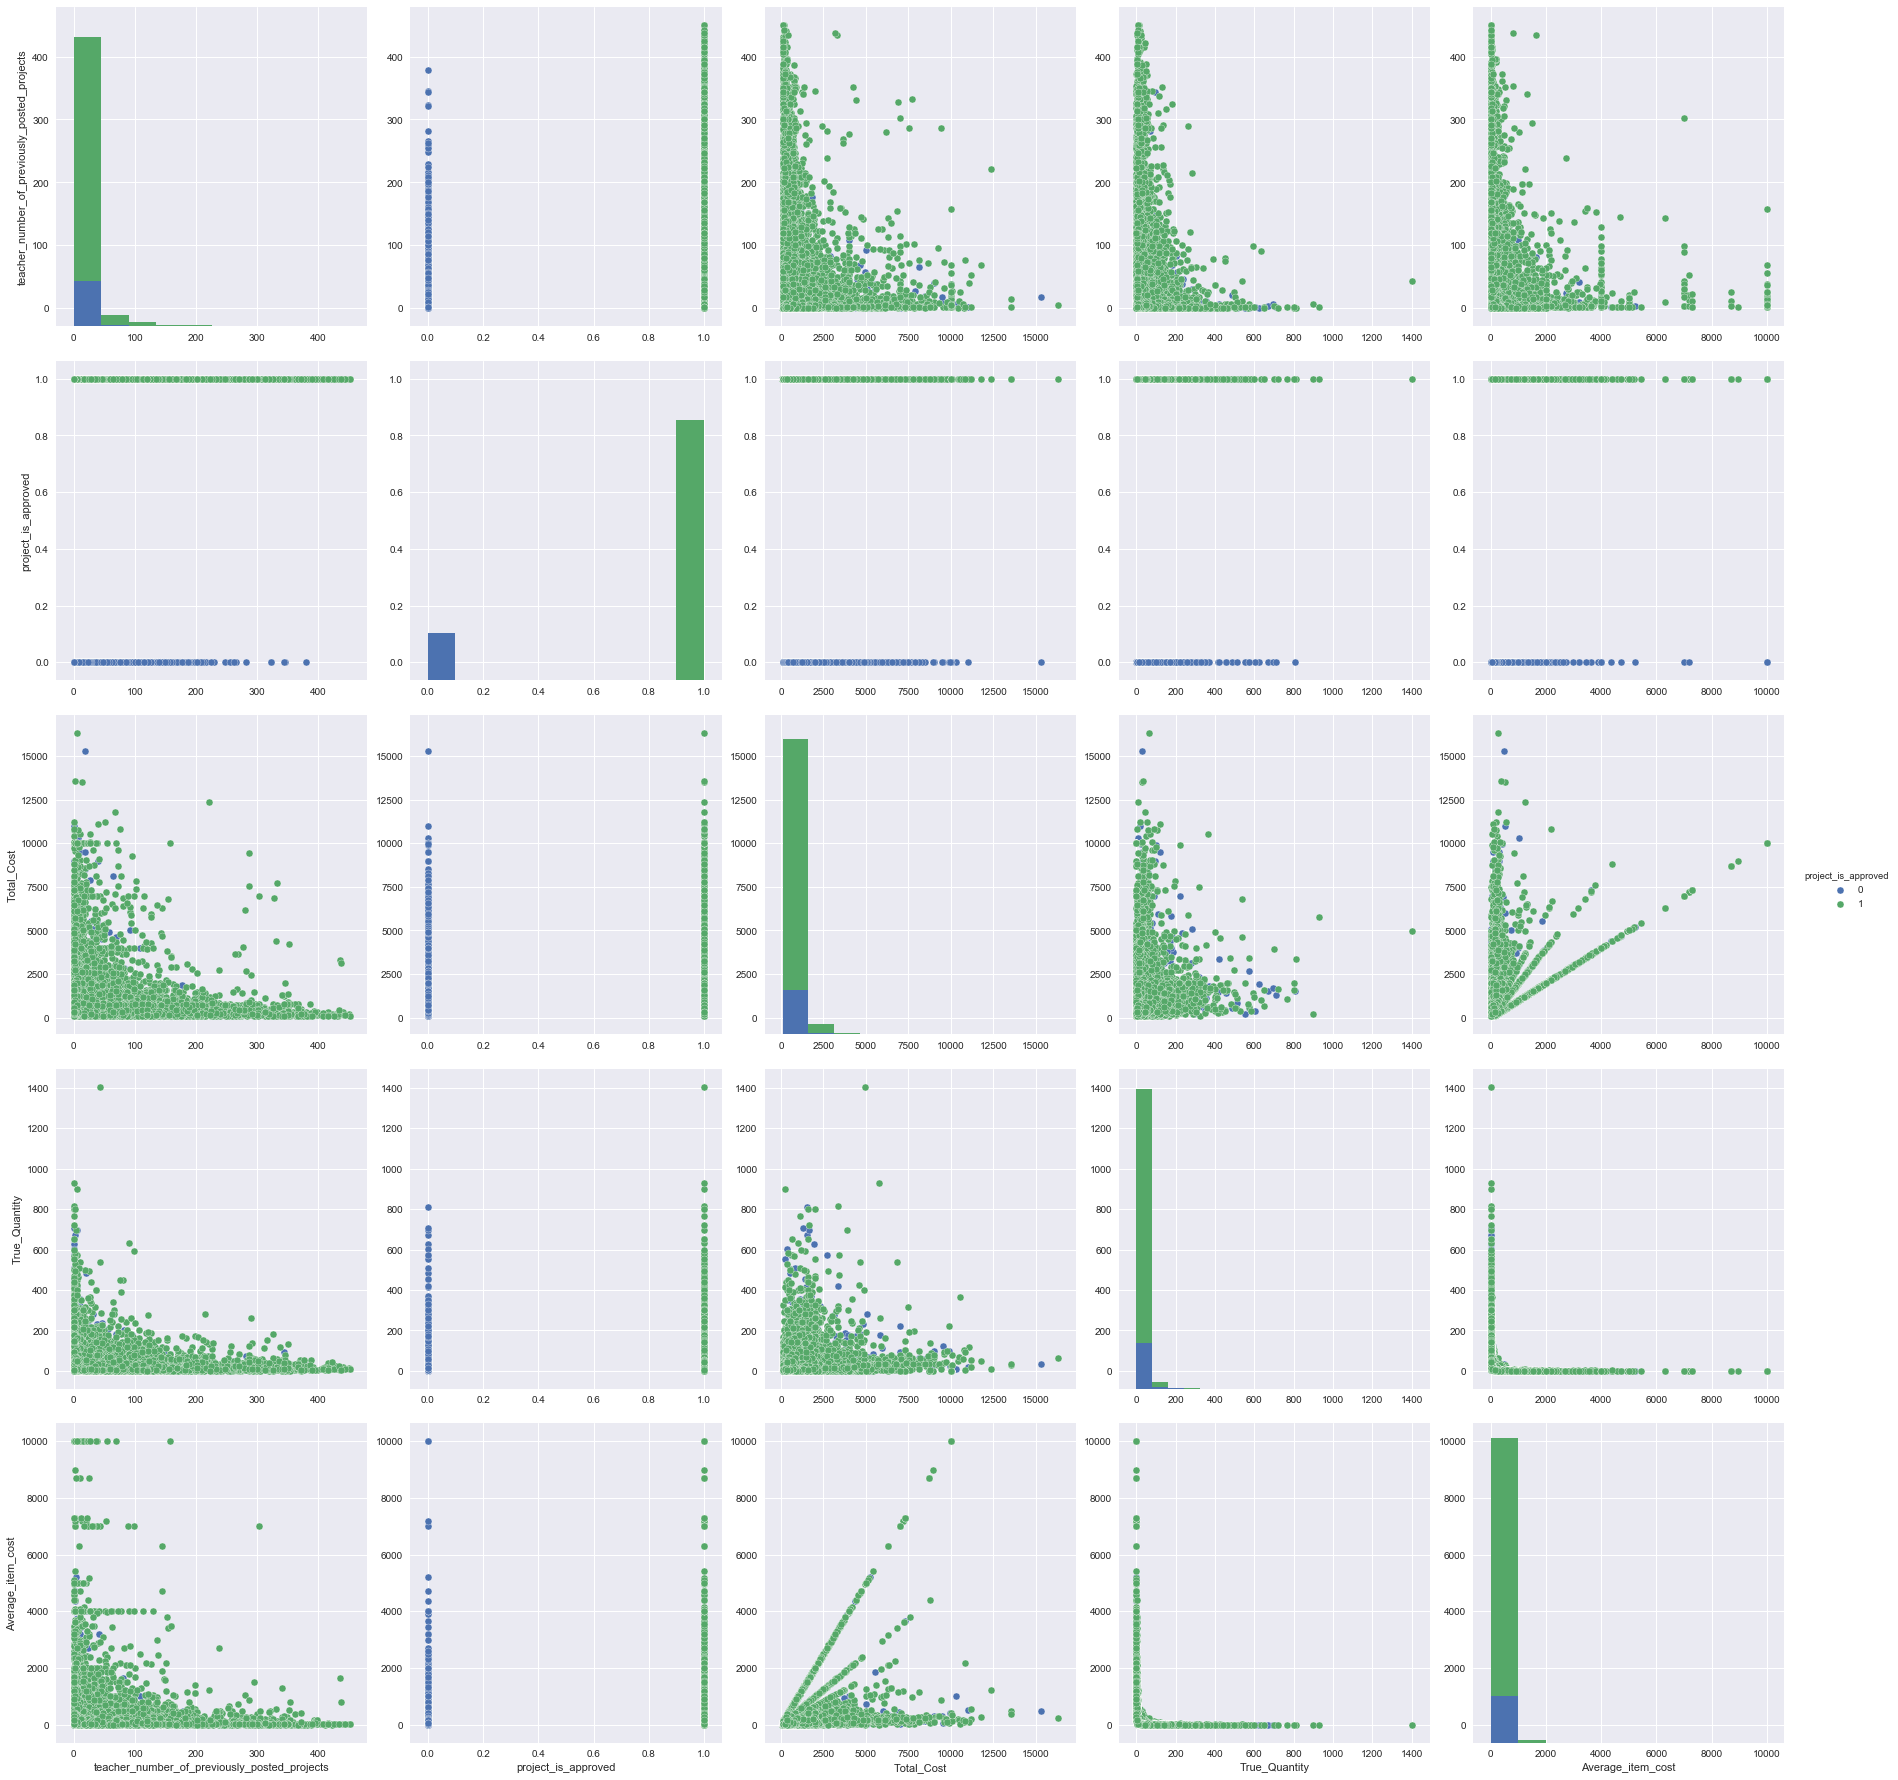

In [8]:
#first delete custom vars made only for visualization
del df_train['proj_submitted_count'] 
del df_train['project_submitted_datetime']
del df_train['project_submitted_YM']
del df_train['total_quantity_group']
del df_train['total_cost_group']

sns.pairplot(df_train,hue="project_is_approved", diag_kind = 'hist', size=5)
plt.show()

The first detail we'll pay attention to is what appears to be an extreme right skew for quantity, total cost, and the number of previously submitted projects.  This can be seen along the diagonal of the scatter plot above.  Since all of these attributes have the same general skew, the plots between variables exibits a similar skew.  

Let's take a closer look at quantity and total cost.

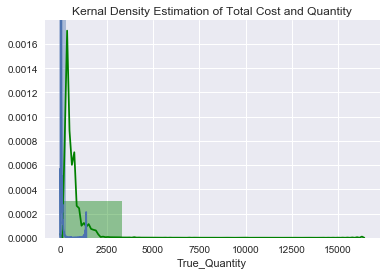

In [10]:
sns.distplot(df_train["Total_Cost"].dropna(), bins=5, kde=True, color = 'green')
sns.distplot(df_train["True_Quantity"].dropna(), bins=5, kde=True)
plt.title('Kernal Density Estimation of Total Cost and Quantity')
plt.show()

The chart above shows quantity and total cost (green line) in a kernal density plot.  The right skew is so extreme that it is difficult to differentiate between the two.

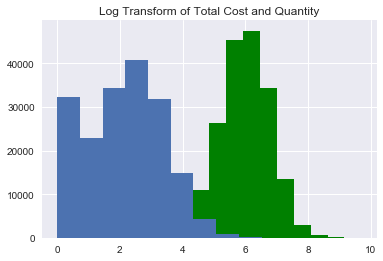

In [11]:
df_train["Total_Cost"].apply(np.log).hist(color='green')
df_train["True_Quantity"].apply(np.log).hist()
plt.title('Log Transform of Total Cost and Quantity')
plt.show()

The histogram above shows the same two attributes, quantity and total cost - but with a log transform.  The log transform seems to greatly improve the distributions of the histogram.  They both appear fairly normal now and it is easy to differentiate between the two.

Let's do the same analysis for previously submitted projects.

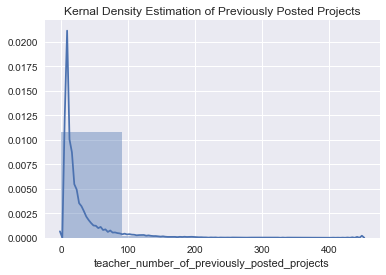

In [12]:
sns.distplot(df_train["teacher_number_of_previously_posted_projects"], bins=5, kde=True)
plt.title('Kernal Density Estimation of Previously Posted Projects')
plt.show()

The above kernal density plot for number of previously posted projects exihits a similar skew as was seen for quantity and total cost.  Again, we will perform a log transform on this attribute to see if this helps to normalize the distributions.

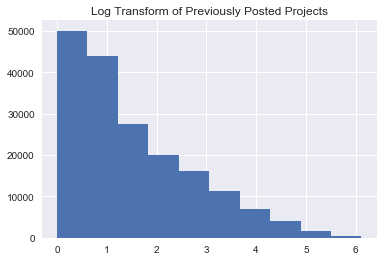

In [13]:
number = df_train["teacher_number_of_previously_posted_projects"]+1
number.apply(np.log).hist()
plt.title('Log Transform of Previously Posted Projects')
plt.show()

The histogram above uses a log transform to give a better visualization of the distribution of previously posted projects.  Although the distribution is still not normal, we are still able to get a better idea of the overall distributions and looks similar to the histogram we saw in the simple statistics section where the prvevious posted projects was limited to <21.

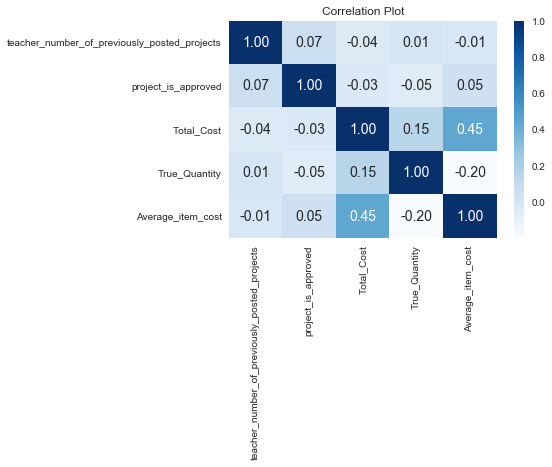

In [14]:
sns.heatmap(df_train.corr(), annot=True, fmt=".2f", cmap = 'Blues')
plt.title('Correlation Plot')
plt.show()

The chart above is a correlation plot for the discrete and continuous variables in our data set.  

From this we see that the highest correlation is of total cost to average cost.  This is trivial as average cost is a linear combination of total cost.  The second highest correlation is between average cost and quantity.  This is a negative correlation and is as we expected from our previuos analysis.  The third highest correlation is between previosly posted projects and project is approved.  This is a positive correlation and is also expected from our earlier analysis.

Although the correlations show what we expected to see in terms of polarity, it is important to note that none of the non-trivial relationships show a particularly strong correlation quantitatively.

### Summary

Some important insights have been gained from this analysis.  Overall approval rates are high, and the chances of an application being approved are increased for those who request lower quantities and lower total costs in their applications.  The volume of total applications submitted also increases the likelyhood of acceptance.  Timing may also be a factor for approval, although a data set that contained a longer time period would be helpful to perform further analysis for this.  Teachers in certain states seem to have better overall odds of application acceptance.  As mentioned earlier, it would be interesting to overlay additional socio-economic attributes to see if this can help to add more insight into the differences amongst states.  Finally, although these relationships are better understood, the weak overall correlation and extreme skew of the explanatory variables will most likely make the overall prediction of approval or denial more difficult and data transformations such as log transforms will need to be applied.